# UCI regression eval

In [1]:
import jax
import os
import re
import datagen
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "EKF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold",
    "OGD": "blueviolet",
    "EKF-B": "darkorange",
    # "WLF-OGD": "silver",
}

In [3]:
from matplotlib import colors
cmap_rgb = {
    c: colors.cnames[v]
    for c, v in cmap.items()
}
cmap_rgb

{'EKF-IW': '#DC143C',
 'WLF-IMQ': '#1E90FF',
 'EKF': '#20B2AA',
 'WLF-MD': '#FFD700',
 'OGD': '#8A2BE2',
 'EKF-B': '#FF8C00'}

In [4]:
path_base = "./results"
# experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error" not in f)]
experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error10" in f)]
sorted(experiment_names)

info_datasets = []
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    nrows, ncols = dataset.shape
    
    info_datasets.append({
        "dataset": dataset_name.split("-")[0].capitalize(),
        "nrows": nrows,
        "ncols": ncols
    })

info_datasets = pd.DataFrame(info_datasets).sort_values("dataset")
info_datasets

,dataset,nrows,ncols
3,Bostonhousing,507,14
5,Concrete,1031,9
6,Energy,769,9
7,Kin8nm,8193,9
1,Naval,11935,18
4,Power,9569,5
0,Protein,45731,10
2,Wine,1600,12
8,Yacht,309,7


In [5]:
df_results_all = []
for file_name in experiment_names:
    dataset = file_name.replace("-target.pkl", "")
    path = os.path.join(path_base, file_name)
    with open(path, "rb") as f:
        experiment = pickle.load(f)

    errors = jax.tree_map(lambda x: np.power(x - experiment["datasets"]["y"], 2), experiment["posterior-states"])
    
    running_times = experiment["time"].copy()
    # del running_times["EKF-B"]    # REMOVE AFTER REFACTORING
    running_times = pd.DataFrame(running_times)

    df_results = pd.DataFrame({
        name: np.median(errors[name], axis=1)
        for name in errors
    })

    df_results = df_results.reset_index().melt("index", value_name="err")
    running_times = running_times.reset_index().melt("index", value_name="time")
    
    df_results = pd.merge(
        df_results,
        running_times,
        on=["index", "variable"],
    )
    
    df_results["dataset"] = dataset
    df_results_all.append(df_results)

df_results_all = pd.concat(df_results_all, axis=0)

# Root median squared error
df_results_all["err"] = np.sqrt(df_results_all["err"])
df_results_all["dataset"] = df_results_all["dataset"].str.replace("-.*", "", regex=True).str.capitalize()
df_results_all = df_results_all.rename({"index": "run", "variable": "method"}, axis=1)
df_results_all = df_results_all.merge(info_datasets, on="dataset")
df_results_all["method"] = df_results_all["method"].apply(lambda x: x.replace("KF", "EKF"))

df_results_all = df_results_all.query("run > 0")
df_results_all = df_results_all.query("method != 'WLF-OGD'")

In [6]:
df_results_all.sample(10, random_state=314)

,run,method,err,time,dataset,nrows,ncols
2114,14,EKF,1.353681,0.009652,Bostonhousing,507,14
5688,88,EKF,0.547524,0.221073,Naval,11935,18
2319,19,EKF-IW,0.317397,0.052560,Bostonhousing,507,14
4436,36,EKF-IW,0.149314,0.286014,Wine,1600,12
1830,30,WLF-IMQ,0.192020,0.115778,Kin8nm,8193,9
1995,95,WLF-MD,0.194348,0.115941,Kin8nm,8193,9
3137,37,OGD,0.388599,0.075624,Power,9569,5
2846,46,EKF,0.519065,0.111821,Power,9569,5
2264,64,EKF-B,0.198961,0.086776,Bostonhousing,507,14
4496,96,EKF-IW,0.146038,0.286002,Wine,1600,12


In [7]:
df_results_all["timestep"] = df_results_all["time"] / (df_results_all["nrows"]) * 1e6

In [8]:
datasets = sorted(df_results_all.dataset.unique())
print(datasets)

['Bostonhousing', 'Concrete', 'Energy', 'Kin8nm', 'Naval', 'Power', 'Protein', 'Wine', 'Yacht']


In [9]:
df_results_all.pivot_table(columns="method", index="dataset", values="err", aggfunc="median")

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,1.365663,0.201048,0.213311,0.530749,0.193207,0.202967
Concrete,0.751237,0.237399,0.240391,0.424976,0.233316,0.238478
Energy,0.848607,0.390911,0.386731,0.590112,0.390130,0.389251
Kin8nm,0.518565,0.196640,0.199704,0.426767,0.197654,0.196755
Naval,0.541604,0.305352,0.308743,0.336644,0.307138,0.307119
Power,0.515047,0.268043,0.268003,0.385962,0.267539,0.268103
Protein,0.449905,0.284123,0.278144,0.360105,0.190890,0.186785
Wine,0.744419,0.147906,0.148991,0.391822,0.148226,0.148283
Yacht,1.126461,0.239606,0.145542,0.544987,0.259142,0.247963


In [10]:
markers = {
    "EKF": "v",
    "EKF-B": "^",
    "EKF-IW": "D",
    "WLF-IMQ": "o",
    "WLF-MD": "*",
    "OGD": "s"
}


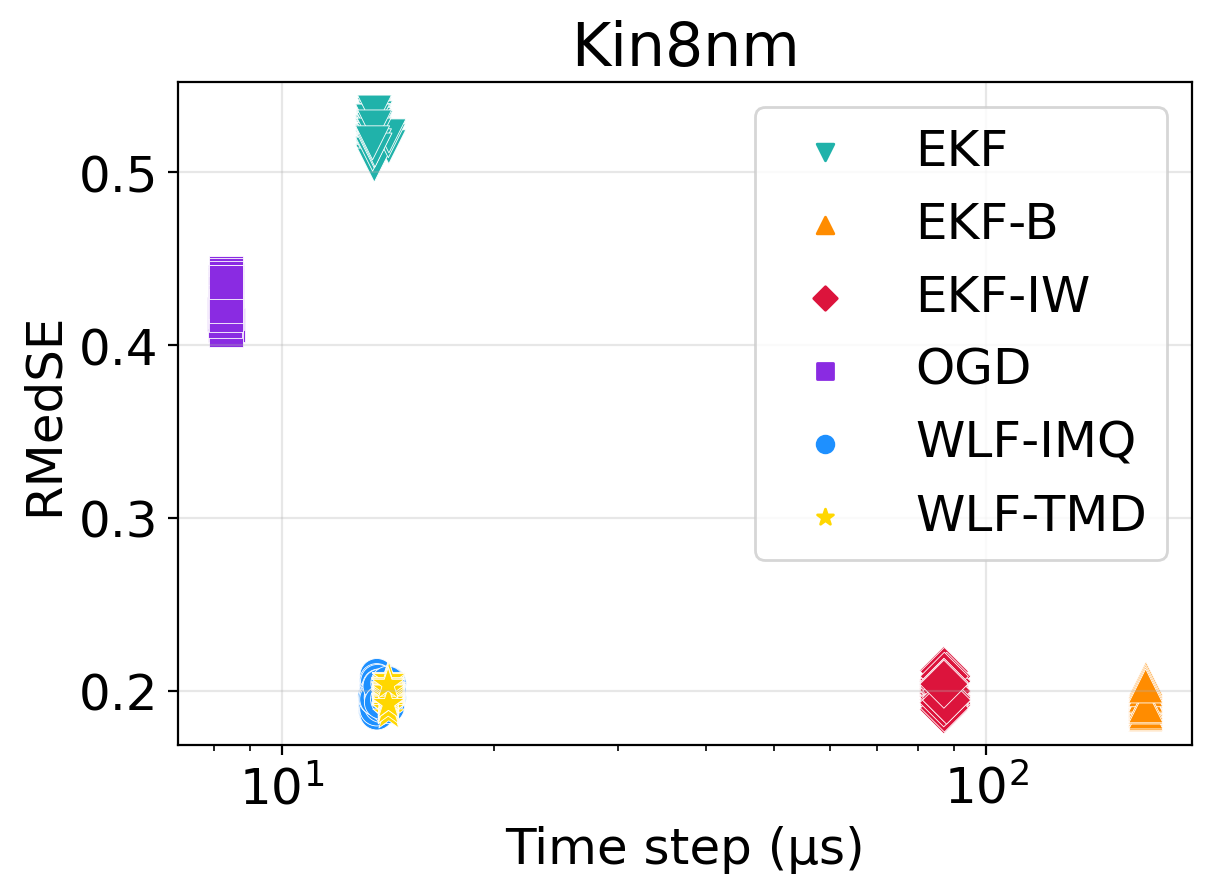

In [12]:
algorithms = sorted(cmap.keys())

dataset = "Kin8nm"
p = sns.scatterplot(
    y="err", x="timestep", hue="method", style="method",
    markers=markers,
    data=df_results_all.query("dataset == @dataset").query("run > 0"),
    palette=cmap, s=150,
    hue_order=algorithms,
    linewidth=0.3,
)
# plt.yscale("log")
# plt.xscale("log")
plt.legend(ncol=1, loc="upper right")

for text in p.legend(ncol=1, loc="upper right").texts:
    text.set_text(text.get_text().replace("-MD", "-TMD"))


plt.title(dataset)
plt.xlabel("Time step (μs)")
plt.ylabel("RMedSE")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.xscale("log")
plt.savefig(f"./figures/{dataset.lower()}-time-v-err.png", dpi=300)

In [13]:
summary_timestep = df_results_all.pivot_table(index="dataset", columns="method", values="timestep")

method = "WLF-IMQ"
# Compare running time relative to the WLF-IMQ
summary_timestep.div(summary_timestep["WLF-IMQ"], axis="rows")

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,1.009064,8.962768,5.459576,0.514945,1.0,1.031579
Concrete,0.986208,12.960231,4.329520,0.617519,1.0,1.029151
Energy,0.994599,7.948420,3.432931,0.609704,1.0,1.029788
Kin8nm,0.984082,12.248728,6.341282,0.604503,1.0,1.028857
Naval,0.987478,11.520039,7.042878,0.440476,1.0,1.002949
Power,0.986831,12.902295,9.625179,0.670940,1.0,1.000028
Protein,0.999469,9.697831,7.172104,0.585049,1.0,1.001128
Wine,0.991974,8.821927,10.493421,0.517215,1.0,0.995633
Yacht,0.996652,8.222339,6.038342,2.465738,1.0,1.002016


In [14]:
summary_err = df_results_all.pivot_table(index="dataset", columns="method", values="err")

method = "WLF-IMQ"
# Compare running time relative to the method
summary_err.div(summary_err[method], axis="rows")

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,6.936790,1.038947,1.089646,2.719800,1.0,1.048130
Concrete,3.232643,1.016507,1.031804,1.826101,1.0,1.025102
Energy,2.178482,1.002867,0.997270,1.512819,1.0,1.002464
Kin8nm,2.625795,0.993520,1.012537,2.160829,1.0,0.996801
Naval,1.762232,0.994409,1.004612,1.095538,1.0,0.999515
Power,1.932590,1.000644,1.002229,1.449674,1.0,1.000676
Protein,2.357584,1.488684,1.457980,1.887185,1.0,0.979434
Wine,4.478486,0.995580,1.002945,2.440600,1.0,0.995930
Yacht,4.305588,0.923489,0.559917,2.143346,1.0,0.959533


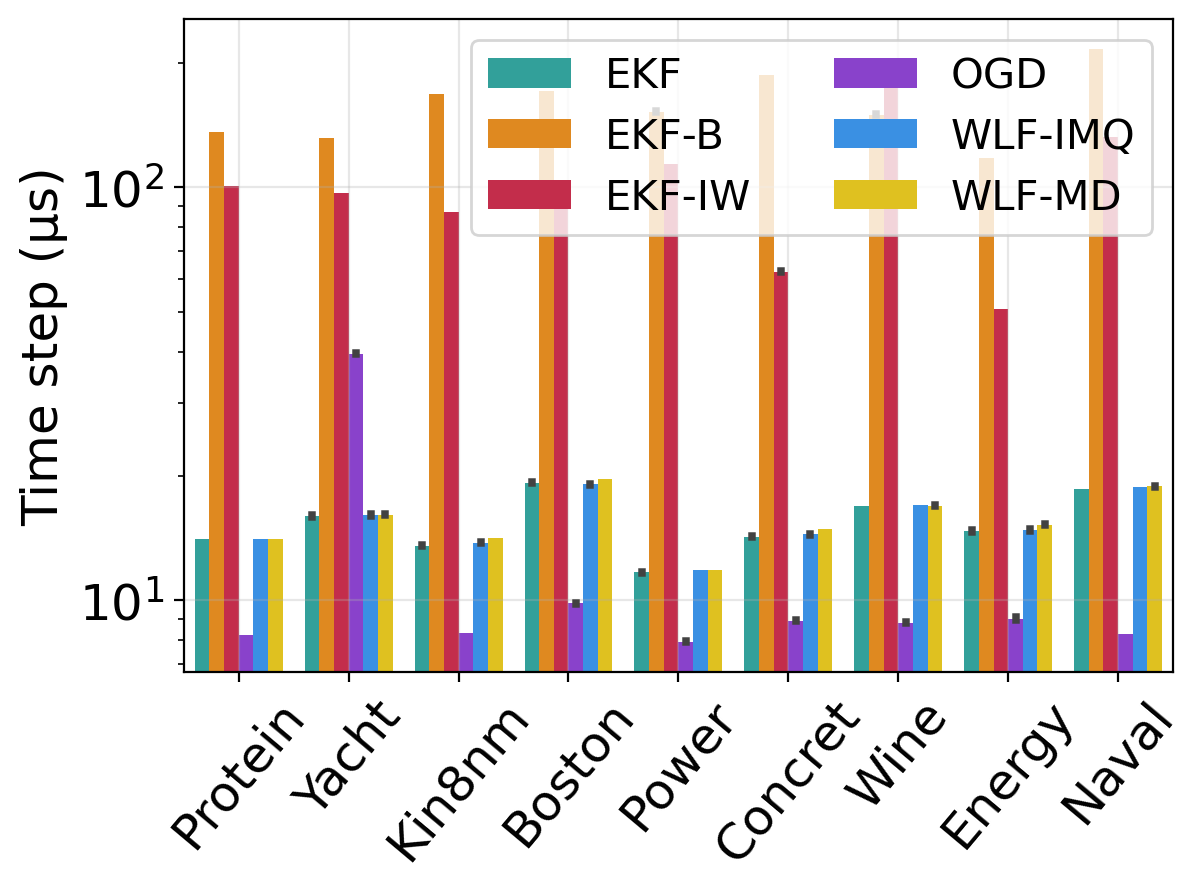

In [15]:
sns.barplot(
    x="dataset",
    y="timestep",
    hue="method",
    palette=cmap,
    data=(
        df_results_all.assign(dataset=df_results_all.dataset.str[:7].str.replace("nh", "n"))
    ),
)
plt.legend(ncol=2, fontsize=15, loc="upper right")
plt.xticks(rotation=50)
plt.grid(alpha=0.3)
plt.xlabel("")
plt.ylabel("Time step (μs)")
plt.tight_layout()
plt.yscale("log")
# plt.savefig(f"./figures/uci-time-comparison.png", dpi=300)

In [16]:
relative_to = "OGD"
metric = "timestep"

for metric in ["err", "timestep"]:
    rel_metric = f"rel_{metric}"
    timestep_ogd = df_results_all.query("method == @relative_to").groupby("dataset")[metric].mean()
    df_results_all[rel_metric] = df_results_all.apply(lambda x: x[metric] / timestep_ogd[x["dataset"]] - 1, axis=1)

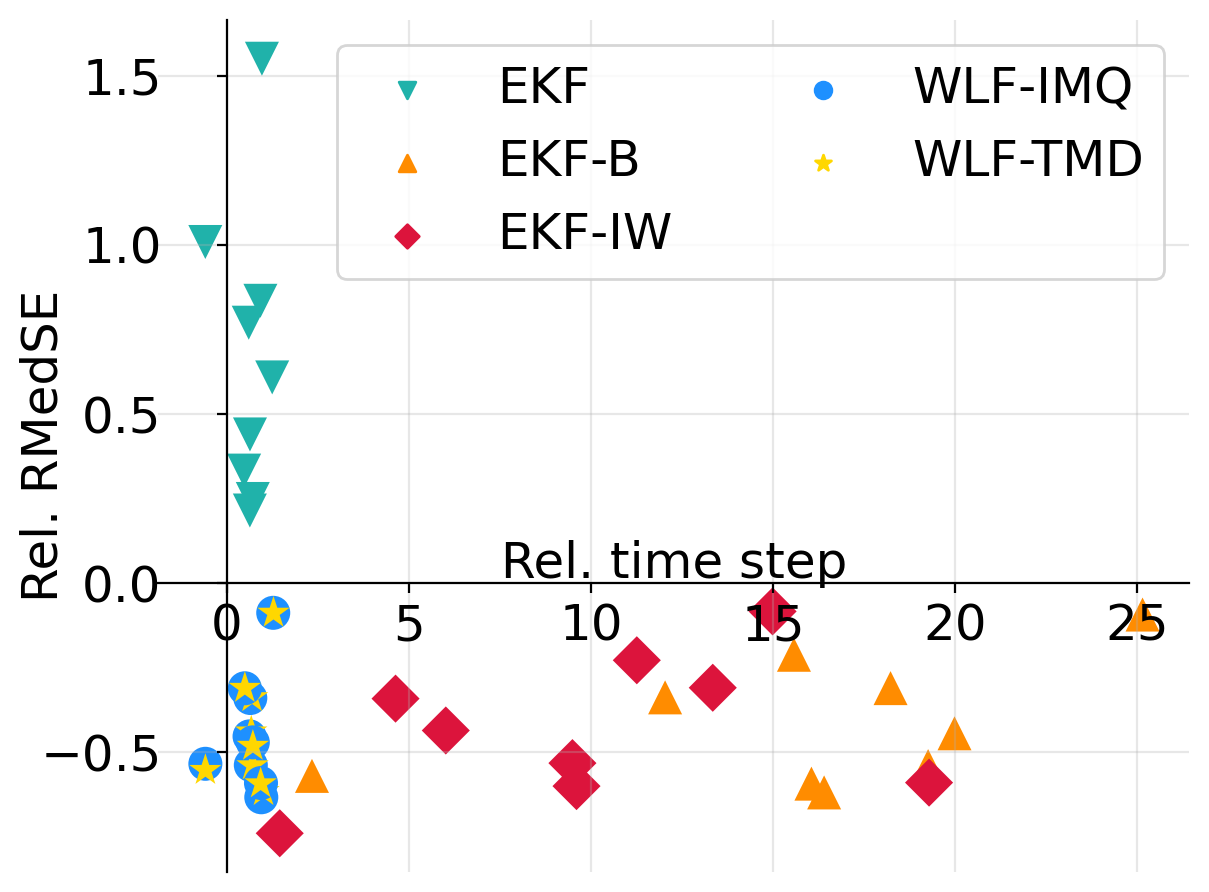

In [17]:
fig, ax = plt.subplots()
outp_df = df_results_all.groupby(["dataset", "method"])[["rel_timestep", "rel_err", "ncols"]].mean().reset_index()
# outp_df = outp_df.melt(["dataset", "method"], var_name="metric")
p = sns.scatterplot(
    x="rel_timestep",
    y="rel_err",
    hue="method",
    data=outp_df.query("method != 'OGD'"),
    palette=cmap,
    s=150,
    markers=markers,
    style="method",
    linewidth=0,
    edgecolor="black"
)
plt.grid(alpha=0.3)

ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)
plt.xticks()
ax.tick_params(direction='out', pad=20, axis="y")

for text in p.legend(ncol=2).texts:
    text.set_text(text.get_text().replace("-MD", "-TMD"))


plt.xlabel("Rel. time step", loc="center", labelpad=-40)
plt.ylabel("Rel. RMedSE", labelpad=-10)
plt.tight_layout()
plt.savefig("./figures/relative-ogd-metrics-datasets.png", dpi=300)

In [18]:
df_results_all.pivot_table(index="method", columns="dataset", values="rel_timestep").style

dataset,Bostonhousing,Concrete,Energy,Kin8nm,Naval,Power,Protein,Wine,Yacht
method,,,,,,,,,
EKF,0.959556,0.597048,0.631282,0.627918,1.241843,0.470820,0.708352,0.917914,-0.595800
EKF-B,16.405285,19.987566,12.036517,19.262461,25.153619,18.230190,15.576115,16.056589,2.334636
EKF-IW,9.602247,6.011148,4.630486,9.490067,14.989247,13.345821,11.258990,19.288308,1.448899
OGD,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
WLF-IMQ,0.941954,0.619382,0.640139,0.654250,1.270272,0.490447,0.709260,0.933431,-0.594442
WLF-MD,1.003279,0.666589,0.688997,0.701987,1.276967,0.490489,0.711189,0.924989,-0.593624


In [19]:
df_results_all.pivot_table(index="method", columns="dataset", values="rel_err").style

dataset,Bostonhousing,Concrete,Energy,Kin8nm,Naval,Power,Protein,Wine,Yacht
method,,,,,,,,,
EKF,1.550478,0.770243,0.440015,0.215180,0.608553,0.333121,0.249260,0.834994,1.008816
EKF-B,-0.618006,-0.443346,-0.337088,-0.540213,-0.092310,-0.309746,-0.211162,-0.592076,-0.569137
EKF-IW,-0.599365,-0.434969,-0.340787,-0.531413,-0.082997,-0.308652,-0.227431,-0.589058,-0.738765
OGD,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
WLF-IMQ,-0.632326,-0.452385,-0.338982,-0.537215,-0.087207,-0.310190,-0.470110,-0.590265,-0.533440
WLF-MD,-0.614630,-0.438639,-0.337354,-0.538695,-0.087649,-0.309723,-0.481008,-0.591932,-0.552320


### Table of results

In [20]:
def format_entry(entry):
    # entry = entry[entry < 1000]
    mean = entry.mean()
    std = entry.std()
    if std > 1000:
        label = rf"$-$"
    else:
        label = rf"${mean:0.2f} \pm {std:0.2f}$"
    return label

In [21]:
res = (
    df_results_all
    .pivot_table(columns="method", index="dataset", values="err", aggfunc=format_entry)
)
res

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,$1.37 \pm 0.05$,$0.20 \pm 0.02$,$0.21 \pm 0.02$,$0.54 \pm 0.04$,$0.20 \pm 0.02$,$0.21 \pm 0.02$
Concrete,$0.75 \pm 0.03$,$0.24 \pm 0.01$,$0.24 \pm 0.01$,$0.43 \pm 0.02$,$0.23 \pm 0.01$,$0.24 \pm 0.01$
Energy,$0.85 \pm 0.04$,$0.39 \pm 0.02$,$0.39 \pm 0.02$,$0.59 \pm 0.03$,$0.39 \pm 0.02$,$0.39 \pm 0.02$
Kin8nm,$0.52 \pm 0.01$,$0.20 \pm 0.00$,$0.20 \pm 0.00$,$0.43 \pm 0.01$,$0.20 \pm 0.00$,$0.20 \pm 0.00$
Naval,$0.54 \pm 0.00$,$0.31 \pm 0.00$,$0.31 \pm 0.00$,$0.34 \pm 0.00$,$0.31 \pm 0.00$,$0.31 \pm 0.00$
Power,$0.52 \pm 0.01$,$0.27 \pm 0.01$,$0.27 \pm 0.01$,$0.39 \pm 0.01$,$0.27 \pm 0.01$,$0.27 \pm 0.01$
Protein,$0.45 \pm 0.00$,$0.28 \pm 0.00$,$0.28 \pm 0.00$,$0.36 \pm 0.00$,$0.19 \pm 0.00$,$0.19 \pm 0.00$
Wine,$0.76 \pm 0.05$,$0.17 \pm 0.03$,$0.17 \pm 0.03$,$0.41 \pm 0.06$,$0.17 \pm 0.03$,$0.17 \pm 0.03$
Yacht,$1.12 \pm 0.04$,$0.24 \pm 0.02$,$0.15 \pm 0.01$,$0.56 \pm 0.06$,$0.26 \pm 0.02$,$0.25 \pm 0.02$


In [22]:
print(res.style.to_latex(hrules=True).replace("_", "-"))

\begin{tabular}{lllllll}
\toprule
method & EKF & EKF-B & EKF-IW & OGD & WLF-IMQ & WLF-MD \\
dataset &  &  &  &  &  &  \\
\midrule
Bostonhousing & $1.37 \pm 0.05$ & $0.20 \pm 0.02$ & $0.21 \pm 0.02$ & $0.54 \pm 0.04$ & $0.20 \pm 0.02$ & $0.21 \pm 0.02$ \\
Concrete & $0.75 \pm 0.03$ & $0.24 \pm 0.01$ & $0.24 \pm 0.01$ & $0.43 \pm 0.02$ & $0.23 \pm 0.01$ & $0.24 \pm 0.01$ \\
Energy & $0.85 \pm 0.04$ & $0.39 \pm 0.02$ & $0.39 \pm 0.02$ & $0.59 \pm 0.03$ & $0.39 \pm 0.02$ & $0.39 \pm 0.02$ \\
Kin8nm & $0.52 \pm 0.01$ & $0.20 \pm 0.00$ & $0.20 \pm 0.00$ & $0.43 \pm 0.01$ & $0.20 \pm 0.00$ & $0.20 \pm 0.00$ \\
Naval & $0.54 \pm 0.00$ & $0.31 \pm 0.00$ & $0.31 \pm 0.00$ & $0.34 \pm 0.00$ & $0.31 \pm 0.00$ & $0.31 \pm 0.00$ \\
Power & $0.52 \pm 0.01$ & $0.27 \pm 0.01$ & $0.27 \pm 0.01$ & $0.39 \pm 0.01$ & $0.27 \pm 0.01$ & $0.27 \pm 0.01$ \\
Protein & $0.45 \pm 0.00$ & $0.28 \pm 0.00$ & $0.28 \pm 0.00$ & $0.36 \pm 0.00$ & $0.19 \pm 0.00$ & $0.19 \pm 0.00$ \\
Wine & $0.76 \pm 0.05$ & $0.17 \pm 0

In [258]:
(
    df_results_all
    .pivot_table(columns="method", index="dataset", values="err", aggfunc=lambda x: (x > 1000).sum())
)

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,0,0,0,0,0,0
Concrete,0,0,0,0,0,0
Energy,0,0,0,0,0,0
Kin8nm,0,0,0,0,0,0
Naval,0,0,0,0,0,0
Power,0,0,0,0,0,0
Protein,0,0,0,0,0,0
Wine,0,0,0,0,0,0
Yacht,0,0,0,0,0,0


## Store config 

In [235]:
dataset_name = "protein-tertiary-structure"
file_name = f"{dataset_name}-target-p-error10.pkl"
path = os.path.join(path_base, file_name)
with open(path, "rb") as f:
    experiment = pickle.load(f)
    hparams = experiment["config"].copy()

In [236]:
config = {}
p_error = experiment["p-error"]
dataset_name = experiment["dataset-name"]
config["metadata"] = {
    "p-error": p_error,
    "dataset-name": dataset_name,
}

config["hyperparams"] = hparams

In [237]:
filename_out = f"hparams-{dataset_name}-p-error{p_error * 100:0.0f}.toml"
filename_out

'hparams-protein-tertiary-structure-p-error10.toml'

In [238]:
path = os.path.join("configs", filename_out)
with open(path, "w") as f:
    toml.dump(config, f, encoder=toml.TomlNumpyEncoder())